In [101]:
# Core libs
import pandas as pd
import numpy as np

# Graphic libs
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
pio.renderers.default = "browser"

# sklearn 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# IA + blockchain = profit
import tensorflow as tf
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Lambda, Dropout, BatchNormalization, Activation, Dense, LeakyReLU
from keras.layers.merging import Add, Concatenate
from keras.utils import plot_model, to_categorical

# Training

In [102]:
## Custom metric
def mape_accuracy(y_true, y_pred):
    correct = tf.reduce_sum(tf.cast( tf.abs((y_true - y_pred)/y_pred) < 0.1, tf.int32), axis=1)
    total = y_true.shape[1]

    return (correct/total)*100

def mape_accuracy_log10(y_true, y_pred):
    correct = tf.reduce_sum(tf.cast(tf.abs(tf.divide(tf.subtract(tf.pow(tf.constant(10, dtype=tf.float32),y_true),tf.pow(tf.constant(10, dtype=tf.float32),y_pred)),tf.pow(tf.constant(10, dtype=tf.float32),y_true))) < 0.1, tf.int32), axis=1)
    #correct = tf.reduce_sum(tf.cast(tf.abs(tf.divide(tf.subtract((y_true + out_center)*out_scale ,(y_pred + out_center)*out_scale),y_true)) < 0.1, tf.int32), axis=1)
    total = y_true.shape[1]

    return (correct/total)*100

## Loading data

In [108]:
NOW = 'LimaPROV'
MASTER_MODEL = 'S4D_Her0/' + NOW + '2.h5'

In [109]:
trainer_data = pd.read_excel('../data/final/'+ NOW +'.xlsx')
trainer_data = trainer_data.drop(['Provincia', 'Distrito'], axis = 1).replace('Centro de Salud',12).replace('Exterior','1').replace('Interior','2').replace('Malo','6').applymap(lambda x : float(x.replace(',','')) if isinstance(x,str) else x)
#trainer_data = trainer_data.drop(['Provincia', 'Distrito'], axis = 1)
trainer_data = trainer_data.applymap(lambda x : np.log10(x + 0.0000001))

log_data = trainer_data.drop(['Valorcomercial'], axis=1)

In [ ]:
log

## RUUUUUUUUUUUUN (Train)

In [93]:
data_pca = PCA()
data_pca.fit(trainer_data)

X = trainer_data.to_numpy().T
components = (data_pca.components_@X).T

Xin = Input(shape=(12,),name='In')
X = Dense(7,activation=tf.keras.activations.softsign)(Xin)
X = Dense(7,activation=tf.keras.activations.softsign)(X)
X = Dense(7,activation=tf.keras.activations.softsign)(X)
X = Dense(7,activation=tf.keras.activations.softsign)(X)
completion = Dense(1, activation='relu')(X)
full_pca_inference = Concatenate(axis=1, name = 'completion')([Xin,completion])
Yout = Lambda(lambda x : tf.transpose(data_pca.components_@tf.transpose(x)))(full_pca_inference)

PCA_model = Model(inputs = Xin, outputs = [Yout], name = 'PCA')

Yfinal = Lambda(lambda x : tf.pow(tf.constant(10, dtype=tf.float32), x))(Yout)
S4D_Her0 = Model(inputs = Xin, outputs = [completion], name = 'predictor')

In [107]:
epochs     = 100        # número de epocas
batch_size = 10         # tamaño del lote
alpha      = 0.00001     # razon de aprendizaje
decay      = 0.00001    # decaimiento de alpha

PCA_model.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                  loss      = 'mae',
                  metrics   = ['accuracy'])

history = PCA_model.fit(x                = log_data,
                        y                = components,
                        batch_size       = batch_size,
                        epochs           = epochs,
                        validation_split = 0.2,
                        verbose          = 1)

ValueError: Data cardinality is ambiguous:
  x sizes: 1400
  y sizes: 975
Make sure all arrays contain the same number of samples.

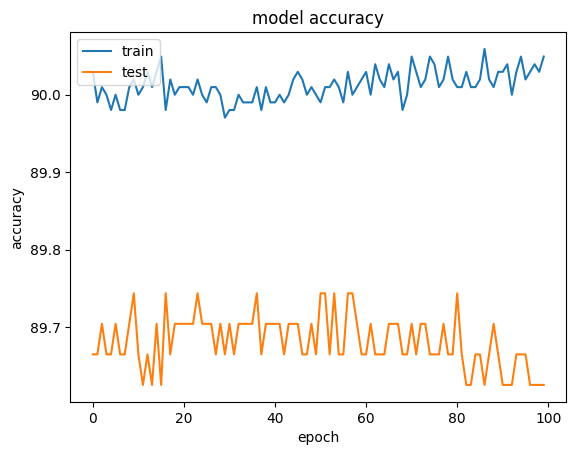

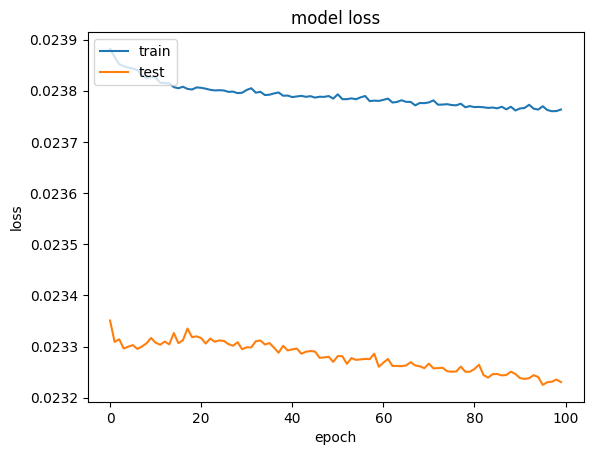

In [98]:
plt.plot(history.history['mape_accuracy_log10'])
plt.plot(history.history['val_mape_accuracy_log10'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [99]:
S4D_Her0.compile(loss      = tf.losses.MeanAbsolutePercentageError(),
                 metrics   = [mape_accuracy])

score = S4D_Her0.evaluate(log_data, trainer_data['Valorcomercial'].to_numpy(), verbose=1)

31/31 [==============================] - 0s 2ms/step - loss: 4.2673 - mape_accuracy: 90.4615


In [100]:
S4D_Her0.save_weights(MASTER_MODEL)